# Setup and Installation

Within this Jupyter notebook we will use **AI as a service** and try an existing service for vision detection. As an example we will use Google's Cloud Vision API.

Google Cloud Vision provides **capabilities for vision detection** through **pre-trained ML models**, including image labeling, face and landmark detection, text detection, and tagging of explicit content. To enable easy integration of these capabilities in your application Google Cloud Vision provides a **REST API** and **client libraries** in different programming languages such as Python.


In [ ]:
# Install the Google Cloud Vision library that allows us to make request to the Google Cloud Vision API
!pip install google-cloud-vision

In [ ]:
# Import the libraries
from google.cloud import vision
import os
import json

To use the Google Vision API you require **access keys**. The access keys contain authorization information for using the API, but no identity information. Each time you want to make a call to Google's Cloud Vision API an access key needs to be provided (in form of a JSON file) which is then used to authenticate and provide authorization information to Google.

**Get your private key file.** For the sake of this tutorial session you can download the JSON file with the private key information from Canvas. If you want to continue using this notebook after the course, you can set up the Vision API for yourself and create your own service account keys (https://cloud.google.com/vision/docs/setup). 

**Copy the content of the private key file into the cell below.**



In [ ]:
credentials = {
##COPY the content of the JSON file here##   

}
    
json_credentials = json.dumps(credentials) 

with open('My Project-543e6ed386ee.json','w') as outfile:
  outfile.write(json_credentials)

In [ ]:
# Using the GOOGLE_APPLICATION_CREDENTIALS environment variable the location of a credential JSON file can be provided. 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'My Project-543e6ed386ee.json'

# Using Google's Vision API

Google's [Cloud Vision API](https://cloud.google.com/vision/docs) provides different vision detection capabilities via a **single endpoint** that supports the annotation of images. 

In [ ]:
# Instantiate the client (this only works with the credantials correctly set)
client = vision.ImageAnnotatorClient()

Each request to the API requires an **image**. One way to provide the image is by specifying the image URI. This can either be a publicly-accessible HTTP or HTTPS URL or a Cloud Storage URI. 

In [ ]:
# Here we use a publicly-accessible URL as image URI
# Before making the request we open the image via its uri and display it
from PIL import Image
import urllib.request

uri = 'https://www.indiewire.com/wp-content/uploads/2016/08/20140216-131646.jpg'
#uri = 'https://cdn.qwiklabs.com/5%2FxwpTRxehGuIRhCz3exglbWOzueKIPikyYj0Rx82L0%3D'

with urllib.request.urlopen(uri) as url:
    img=Image.open(url)
    display(img)

Initialize the image and pass the URI as the value of `image.source.image_uri`.

In [ ]:
# Set image to be analyzed by Google Vision
image = vision.Image()
image.source.image_uri=uri

## Face Detection

A request to the API additionally requires an indication concerning the **types of annotations** to be performed on the image.

For example, `client.face_detection(image=image)` can be used to use the capability of **detecting faces** in images. For a more comprehensive overview of supported feature types see https://cloud.google.com/vision/docs/features-list. 

The **face_detection** feature 
*   locates faces with bounding polygons, 
*   identifies specific facial "landmarks" such as eyes, ears, nose, mouth

along with their corresponding confidence values.

Moreover it returns 
* likelihood ratings for emotion (joy, sorrow, anger, surprise) and 
* general image properties (underexposed, blurred, headwear present).

Likelihoods ratings are expressed as 6 different values: UNKNOWN, VERY_UNLIKELY, UNLIKELY, POSSIBLE, LIKELY, or VERY_LIKELY.

The API provides this information in the response object which is represented in JSON format. The response can be stored in a variable, e.g., `response_faces` to access the above information.

In [ ]:
#### FACE DETECTION ######
## Use the face detection feature of the Google Cloud API and store the result 
response_faces = client.face_detection(image=image)

Let us now inspect the JSON response. 

In [ ]:
##Show the JSON response
print(response_faces)

Since the JSON response provides more information than what we actually need we can further process the response and only extract the data we are interested in. 

**How to access a face?**
The JSON response can potentially contain more than one face. With `response_faces.face_annotations` we can access the different faces and use a loop `for face in response_faces.face_annotations:` to iterate over the different faces. 

**How to access the properties of a single face?**
This then allows us to access the properties of each of the faces. For example, `face.surprise_likelihood ` gives us the surprise likelihood of a particular face.


### Extracting Face Properties

In [ ]:
for face in response_faces.face_annotations:
    print(face.surprise_likelihood)

To make the output look a bit more user-friendly and only show the likelihood name we make a small change to the code.

In [ ]:
# Names of likelihood from google.cloud.vision.enums
likelihood_name = ('UNKNOWN', 'VERY_UNLIKELY', 'UNLIKELY', 'POSSIBLE',
                       'LIKELY', 'VERY_LIKELY')

for face in response_faces.face_annotations:
    print(likelihood_name[face.surprise_likelihood])


Let us now create a string with information concerning all emotion likelihood ratings. For this, wedefine a function called `hasEmotions(face)` which returns for a given face a string with the likelihood ratings for the different emotions (e.g., `Joy: VERY_LIKELY; Sorrow: VERY_UNLIKELY; Anger: VERY_UNLIKELY; Surprise: VERY_UNLIKELY`).

Moreover, let us define a function called `obtainCharacteristics(face)` which returns for a given face a string with the headware likelihood rating (e.g., `Wearing headware: VERY_LIKELY`).

In [ ]:
# Function to create a string with the likelihood rating for the different emotions
def hasEmotions(face):
      emotionStr = 'Joy: {}; Sorrow: {}; Anger: {}; Surprise: {}'.format(likelihood_name[face.joy_likelihood], 
                                                                         likelihood_name[face.sorrow_likelihood], 
                                                                         likelihood_name[face.anger_likelihood],
                                                                         likelihood_name[face.surprise_likelihood])
      return emotionStr

# Function to create a string with the headware likelihood rating
def obtainCharacteristics(face):
        fmtstr = 'Wearing headware: {}'.format(likelihood_name[face.headwear_likelihood])
        return fmtstr


Since the response provided by the API can potentially contain several faces the function defined above needs to be call for each face.

In [ ]:
# For each face the emotion and headware wearing likelihoods are shown
for face in response_faces.face_annotations:
   print(hasEmotions(face))
   print(obtainCharacteristics(face))

### Highlight Faces in Image

Now that we know how to extract face properties, let us go one step further and exploit the info on the bounding boxes to highlight the faces in the image.

To extract the information about a face's bounding box we can use `face.bounding_poly.vertices` to obtain vertices defining the bounding box. For each of the verices we can obtain its coorinates using `vertex.x` and `vertex.y`. 

In [ ]:
for face in response_faces.face_annotations:
   box = [(vertex.x, vertex.y) 
              for vertex in face.bounding_poly.vertices]
   print(box)

The bounding box information can then be used to highlight the faces in the image.

In [ ]:
# Code adapted from https://cloud.google.com/vision/docs/face-tutorial

from PIL import Image as PillowImage
from PIL import ImageDraw

def highlight_faces(img, faces):
    """Draws a polygon around the faces and displays the image with the faces highlighted

    Args:
      img: a file containing the image with the faces.
      faces: a list of faces found in the response file returned by the Vision API.
    """

    draw = ImageDraw.Draw(img)
    
    for face in response_faces.face_annotations:
        
        # For each face a bounding box is added
        box = [(vertex.x, vertex.y) 
              for vertex in face.bounding_poly.vertices]
        draw.line(box + [box[0]], width=5, fill='#00ff00')
        
        # Place the confidence value/score of the detected faces above the
        # detection box in the output image
        draw.text(((face.bounding_poly.vertices)[0].x,
                   (face.bounding_poly.vertices)[0].y - 30),
                  str(format(face.detection_confidence, '.3f')) + '%',
                  fill='#FF0000')
    display(img)
    
highlight_faces(img, response_faces)

## Label Detection 

We already tried the face detection features. Let's now explore some of the other **types of annotations**.

For example, `client.label_detection(image=image)` can be used to use the capability of **detecting labels** in images. For a more comprehensive overview of supported feature types see https://cloud.google.com/vision/docs/features-list. 

The `label_detection` feature provides generalized labels for an image.
For each label it returns 
* a textual description, 
* confidence score, 
* and topicality rating.

If you want to use customized labeling you can use [AutoML Vision](https://cloud.google.com/vision/automl/docs) to create a custom machine learning model for your specific use case. You provide a labeled data set and AutoML Vision does the training for you.

In [ ]:
#### LABEL DETECTION ######

response_label = client.label_detection(image=image)
#print(response_label)

for label in response_label.label_annotations:
    print({'label': label.description, 'score': label.score})

Let us assume that you are interested in whether or not a particular image belongs to a certain class, i.e., contains a certain label.  

Let us define a function `imageContains(response_Label, class_name, threhold)` where `response_Label` refers to the labels detected in the image by Google Cloud Vision API, `class_name` refers to the name of the label that should be contained in the image and `threhold` refers to the minimum confidence score required to consider the image to belong to the respective class. The function returns `True` if the image is considered to belong to the class and `False` otherwise.

In [ ]:
def imageContains(response_label, class_name, threshold):

  for label in response_label.label_annotations:
      if label.description == class_name and label.score >= threshold:
          
          return True
      #print({'label': label.description, 'score': label.score})
  return False

class_name = "Human"
threshold = 0.7

if (imageContains(response_label, class_name, threshold)):
  print("The image contains a {}".format(class_name))
else:
  print("The image does not contain a {}".format(class_name))



## Landmark Detection

Let's now explore the landmark detection. For this, we need to provide an image that contains a landmark.

In [ ]:
# Open an image via its uri and display it
from PIL import Image
import urllib.request

#uri = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQa-ItjJOrVECuwX-xAtN9rNTuNiHl2aHCeSA&usqp=CAU'
#uri = 'https://img.luzernerzeitung.ch/2020/5/26/fbc87bef-bf45-433b-a7ca-5404a9ef37ea.jpeg?width=560&fit=crop&quality=75&auto=webp'
uri = 'https://media.myswitzerland.com/image/fetch/c_lfill,g_auto,w_3200,h_1800/f_auto,q_80,fl_keep_iptc/https://www.myswitzerland.com/-/media/st/gadmin/images/landscapes/winter/mountains/angebot_zermatt_45830.jpg'

with urllib.request.urlopen(uri) as url:
    img=Image.open(url)
    display(img)

# Set image to be analyzed by Google Vision
image = vision.Image()
image.source.image_uri=uri

Using `client.landmark_detection(image=image)` can be used to use the capability of detecting landmarks in images. 

The `landmark_detection` feature provides 
* the name of the landmark, a confidence score and a bounding box in the image for the landmark,
* coordinates for the detected entity.

The JSON response contains landmark_annotations. We can access the details for each of the landmark using a for loop that iterates over the annotations: `for landmark in response_image.landmark_annotations:`.

In [ ]:
#### LANDMARK DETECTION ######

response_image = client.landmark_detection(image=image)
#print(response_image)

for landmark in response_image.landmark_annotations:
    print({'label': landmark.description, 'score': landmark.score})
    for location in landmark.locations:
            lat_lng = location.lat_lng
            print('Latitude {}'.format(lat_lng.latitude))
            print('Longitude {}'.format(lat_lng.longitude))


## Text Detection in Images

Let's now explore optical character recognition (OCR). In particular, `client.text_detection(image=image)` can be used to extract text from images.

The `text_detection` feature provides the entire extracted string, as well as individual words, and their bounding boxes.

In [ ]:
# Open an image via its uri and display it
from PIL import Image as PillowImage
import urllib.request

uri = 'https://www.inside-digital.de/img/whatsapp-geburtstagssprueche2.jpg?class=1200x900'
#uri = 'https://www.galaxus.ch/im/Files/2/8/7/1/1/2/6/5/959002-H-002.xxl3.jpgexportGa4PCo68TlLe9g?impolicy=ProductTileImage&resizeWidth=648&resizeHeight=486&cropWidth=648&cropHeight=486&resizeType=downsize&quality=high'

with urllib.request.urlopen(uri) as url:
    img=Image.open(url)
    display(img)

# Set image to be analyzed by Google Vision
image = vision.Image()
image.source.image_uri=uri

In [ ]:
#### TEXT DETECTION ######

response_text = client.text_detection(image=image)

text=""
if response_text.text_annotations:
  #Only print the entire text, not the individual fragments
  text = response_text.text_annotations[0].description
print(text)

# Adding a Graphical User Interface

We will use Gradio for creating the user interfaces. [Gradio](https://gradio.app) allows an easy and fast way to demo your machine learning applications. Gradio is a Python library that automatically generates a web interface to demo a machine learning model.

In [ ]:
#Here we install gradio
!pip install gradio

So far, we have used the Google Vision API by providing a URI to a resource in the internet (either a publicly available HTTP or HTTPS URL or a cloud resource). Now we would like to use the API for an image that is uploaded by the user via a graphical user interace created using Gradio. Since we do not have a URI in this case, we can use the `image.content` parameter (rather than the `image.source_uri` property). This property expects a byte stream of an image.

Since the image is provided by Gradio in a format that is different to what the Google Cloud Vision API can handle, we need some helper code to bring the image into the right format (i.e., into a byte array).

In [ ]:
#Import libraries
from PIL import Image as PillowImage
import io

In [ ]:
# Adapted from https://stackoverflow.com/questions/33101935/convert-pil-image-to-byte-array
# Conversion of image into byte array
def image_to_byte_array(filePath) -> bytes:
  #Open File as PIL Image
  pil = PillowImage.open(filePath, "r")   
  # BytesIO is a fake file stored in memory
  imgByteArr = io.BytesIO()
  # image.save expects a file as a argument, passing BytesIO object
  pil.save(imgByteArr, format=pil.format)
  # Turn the BytesIO object back into a bytes object
  imgByteArr = imgByteArr.getvalue()
  return imgByteArr

## UI for Face Detection


To be able to connect the capabilities for facial recognition with Gradio we need to specify a function which is called upon upload. It takes the filename of the uploaded file as input and returns a list with emotion ratings and headware likelihood ratings which are then displayed as output.

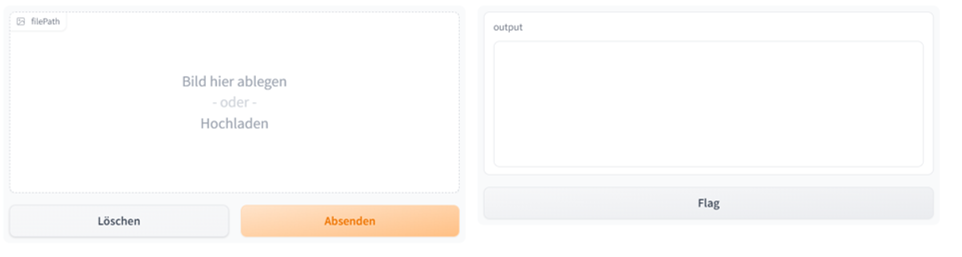

In [ ]:
# Face detection
# This function is called once the image file is uploaded using the Gradio UI
def detect_face(filePath):

   # Google Vision requires the image as byte array; here we convert the file and set it as the new image content
   # Set image to be analyzed by Google Vision
   image = vision.Image()
   image.content = image_to_byte_array(filePath)

   #Use the face_detection feature
   faces = client.face_detection(image=image)
   #print(faces)
  
   faceList = []  
   for face in faces.face_annotations:
      faceList.append(hasEmotions(face))
      faceList.append(obtainCharacteristics(face))
   
   #The faceList is returned as output to Gradio and shown in the TextArea; for each face two entries are shown: one for the emotions and one for the headware
   return faceList

The interface can be created with just a few lines of code. A Gradio `Interface` has three parameters:

*   The function which is called
*   An input component such as an Image
*   An output component such as a TextArea

Once the interface has been created it needs to be launched. To see debug information you can set `debug=True`.



In [ ]:
import gradio as grad
demo = grad.Interface(
    detect_face, 
    inputs=grad.Image(type="filepath"),
    outputs = grad.TextArea()
)
demo.launch(debug=True)

## UI for Label Detection

For the label detection we will not use a TextArea for the output but  a Gradio component called `Label`. A label component allows to show labels with the corresponding confidence scores. For this a dictionary needs to be passed to the function with the label as `str` and the confidence score as `float`. 

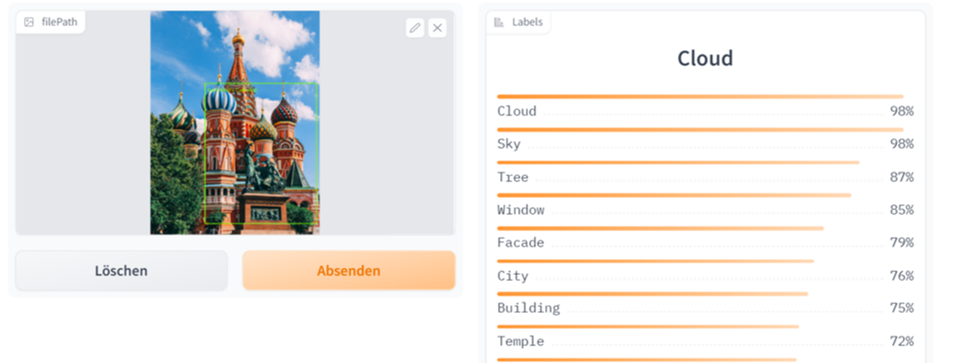

In [ ]:
#### LABEL DETECTION ######

def detect_label(filePath):

   # Google Vision requires the image as byte array; here we convert the file  
   img = vision.Image()
   img.content = image_to_byte_array(filePath)

   # Use the label detection feature
   response_label = client.label_detection(image=img)

   # Creates a dictionary with the label description as key and the score as value
   labelDic = {}
   for label in response_label.label_annotations:
     labelDic[label.description]=label.score
     #print({'label': label.description, 'score': label.score})

   # The dictionary with all labels is returned  
   return labelDic

In [ ]:
import gradio as grad
demo = grad.Interface(
    detect_label, 
    inputs=grad.Image(type="filepath"),
    #grad.Label can be used for dictionaries where the key is a str and the score is a float
    outputs = grad.Label(label="Labels")
)
demo.launch(debug=True)

## Exercises

### Exercise 1: Add a UI for Landmark Detection

In [ ]:
##Add here a function which allows you to detect landmarks using the Google Vision API

def detect_landmark(filePath):

   # Google Vision requires the image as byte array; here we convert the file  
   img = vision.Image()
   img.content = image_to_byte_array(filePath)

   #### Add here the code for LANDMARK DETECTION ######
   response_image = client.landmark_detection(image=img)
   
   landmarkDict = {}
   
   ## Add here the code to add for each landmark the description and the score to the landmarkDict
   for landmark in response_image.landmark_annotations:
     landmarkDict[landmark.description]=landmark.score
   #print(landmarkDict)
   return landmarkDict

In [ ]:
##Add here a gradio userinterace that allows to upload an image and 
##which shows for each identified landmark the label and the score

import gradio as grad

## Add here the code for creating a gradio user interface
##The interface should call the function dect_landmark when a new file is uploaded
##The output should be a Label component which shows for each landmark the score

demo = grad.Interface(
    detect_landmark, 
    inputs=grad.Image(type="filepath"),
    outputs = grad.Label(label="Labels")
)

##Add here the code to launch the user interface
demo.launch(debug=True)

### Exercise 2: Add a UI for Text Detection

In [ ]:
##Add here a function which allows you to detect text using the Google Vision API

def detect_text(filePath):

   # Google Vision requires the image as byte array; here we convert the file  
   img = vision.Image()
   img.content = image_to_byte_array(filePath)

   #### Add here the code for Text DETECTION ######
   response_text = client.text_detection(image=img)
   
   text=""
   
   ## Add here the code to access the description of the text annotation:

   if response_text.text_annotations:
     text = response_text.text_annotations[0].description
   ##  print(text)
   return text

In [ ]:
import gradio as grad

##Add here a gradio userinterace that allows to upload an image and 
##which shows the description for the overall text identified
##The interface should call the function detect_text when a new file is uploaded
##The output should be a TextArea component which shows for the text

demo = grad.Interface(
    detect_text, 
    inputs=grad.Image(type="filepath"),
    outputs = grad.TextArea()
)


##Add here the code to launch the user interface
demo.launch(debug=True)